In [1]:
import pandas as pd
from datetime import datetime
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="white")
%matplotlib inline

In [2]:
actors_path = os.path.join(os.getcwd(), "movies-1990-to-2017", "Movie_Actors.csv")
additional_ratings_path = os.path.join(os.getcwd(), "movies-1990-to-2017", "Movie_AdditionalRating.csv")
genres_path = os.path.join(os.getcwd(), "movies-1990-to-2017", "Movie_Genres.csv")
movies_path = os.path.join(os.getcwd(), "movies-1990-to-2017", "Movie_Movies.csv")
writer_path = os.path.join(os.getcwd(), "movies-1990-to-2017", "Movie_Writer.csv")

In [3]:
actors = pd.read_csv(actors_path, sep=',')
additional_ratings = pd.read_csv(additional_ratings_path, sep=',')
genres = pd.read_csv(genres_path, sep=',')
movies = pd.read_csv(movies_path,sep=',')
writer = pd.read_csv(writer_path,sep=',')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Questions

# 1. Does the Genre correlate with the given Scoring?

### 1.1 Data Cleaning

Removing 'Unamed 0' columns

In [4]:
movies.drop(['Unnamed: 0'],axis=1,inplace=True)
genres.drop(['Unnamed: 0'],axis=1,inplace=True)

Selecting only movies with imdbRating

In [5]:
movies_with_rating = movies[pd.notnull(movies.imdbRating)].copy()

Selecting only needed columns

In [6]:
movies_with_rating = movies_with_rating[['imdbID','imdbRating','imdbVotes','Metascore']]

Checking column types

In [7]:
movies_with_rating.dtypes

imdbID         object
imdbRating    float64
imdbVotes      object
Metascore     float64
dtype: object

We can check that imdbVotes is a object field, but we need to look at it as a numeric field

In [8]:
movies_with_rating.imdbVotes.unique()

array(['35', '345', '11', ..., '110,566', '132,448', '151,938'],
      dtype=object)

In [9]:
movies_with_rating['imdbVotes'].fillna(0,inplace=True)
movies_with_rating['imdbVotes'] = movies_with_rating.imdbVotes.apply(lambda x: np.int64(str(x).replace(',','')))

It seems that we have some cases where the movie genre has a whitespace as first char duplicating genres names. We have to handle this to analyse the data correctly

In [10]:
genres.Genre.unique()

array(['Short', ' Drama', 'Drama', ' Romance', 'Documentary', ' Short',
       ' Crime', ' Comedy', ' Mystery', 'Sport', 'Horror', ' Thriller',
       'Music', 'Comedy', ' Horror', 'Animation', ' Family', ' Sci-Fi',
       'Adventure', 'Adult', ' War', ' Music', 'Western', 'Romance',
       'Thriller', 'Crime', 'Fantasy', ' Biography', ' Action',
       'Biography', ' Western', 'Reality-TV', 'Action', ' Adventure',
       ' History', ' Documentary', ' News', ' Fantasy', ' Musical',
       'History', 'Sci-Fi', ' Reality-TV', 'Family', ' Sport',
       ' Animation', ' Adult', 'News', 'Musical', 'Mystery', ' Game-Show',
       'Talk-Show', 'Film-Noir', ' Talk-Show', ' Film-Noir', 'War',
       'Game-Show'], dtype=object)

In [11]:
genres['Genre'] = genres.Genre.apply(lambda x: x.replace(' ',''))

In [12]:
genres.Genre.unique()

array(['Short', 'Drama', 'Romance', 'Documentary', 'Crime', 'Comedy',
       'Mystery', 'Sport', 'Horror', 'Thriller', 'Music', 'Animation',
       'Family', 'Sci-Fi', 'Adventure', 'Adult', 'War', 'Western',
       'Fantasy', 'Biography', 'Action', 'Reality-TV', 'History', 'News',
       'Musical', 'Game-Show', 'Talk-Show', 'Film-Noir'], dtype=object)

### 1.2 Data Transform

#### Merging dataframes

In [13]:
movies_genres = pd.merge(movies_with_rating, genres, on='imdbID', how='inner')

In [14]:
movies_genres.head()

,imdbID,imdbRating,imdbVotes,Metascore,Genre
0,tt1006835,6.9,35,NaN,Documentary
1,tt1006835,6.9,35,NaN,Short
2,tt2554714,2.4,345,NaN,Horror
3,tt2554714,2.4,345,NaN,Thriller
4,tt1090670,6.3,11,NaN,Music


Now, let's create a pivot_table containing some simple statistical metrics that will help us explain some particularities of the dataset. For now, we'll use count,sum,mean, standard deviation, min, max of imdbRating

In [15]:
preliminar_analysis = pd.DataFrame(movies_genres.pivot_table(index=['Genre'], values=['imdbRating'], aggfunc=['count','sum','mean',np.std, 'min','max'])).reset_index()

Here we just getting rid of the multi-index columns a turning into a simple index columns

In [16]:
preliminar_analysis.columns = preliminar_analysis.columns.droplevel(1)
preliminar_analysis = preliminar_analysis.rename_axis(None, axis=1)

Since we're looking for a correlation between the score and genre, a good metric to look on is variation coefficient because it will show how homogeneous is the score in each movie genre.

In [17]:
preliminar_analysis['coef_variaton'] = preliminar_analysis.apply(lambda x: (x['std']/x['mean'])*100.0, axis=1)

In [18]:
preliminar_analysis.head(2)

,Genre,count,sum,mean,std,min,max,coef_variaton
0,Action,5284,31321.8,5.927668,1.395634,1.0,10.0,23.544398
1,Adult,2474,15978.0,6.458367,1.263755,1.0,10.0,19.567720


### 1.3 Analysis 

Now let's plot a graph to check the variation coef in each genre

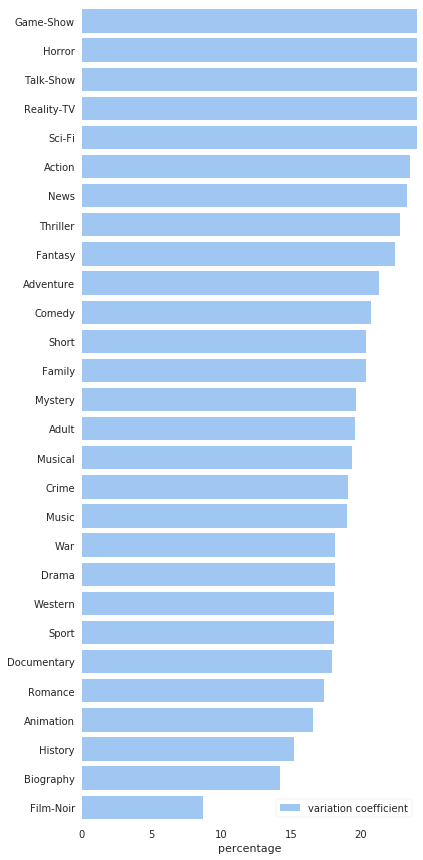

In [19]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
preliminar_analysis = preliminar_analysis.sort_values("coef_variaton", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="coef_variaton", y="Genre", data=preliminar_analysis,
            label="variation coefficient", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="percentage")
sns.despine(left=True, bottom=True)

### 1.4 Conclusion 

If we consider that:

1) lower or equal to 15% → low dispersion: homogenous data

2) between 15 and 30% → average dispersion

3) higher than 30% → heterogenous data

Then the majority of the genres have an average dispersion and only history, biography, film-noir are more homogenous. So there is no correlation between the genre and the given rating, since the majority of the cases have the same data behavior.

# 2. Can we see a hype of specific genre over the past years?

### 2.1 Data Cleaning

Checking which column to use

In [20]:
movies.columns

Index(['Awards', 'BoxOffice', 'Country', 'DVD', 'Director', 'Language',
       'Metascore', 'Plot', 'Poster', 'Production', 'Rated', 'Released',
       'Response', 'Runtime', 'Title', 'Type', 'Website', 'Year', 'imdbID',
       'imdbRating', 'imdbVotes'],
      dtype='object')

In [21]:
movies_released = movies[['imdbID','Year']].copy()

Checking if the types are looking as we aspect and NO (of course...)

In [22]:
movies_released.dtypes

imdbID    object
Year      object
dtype: object

Lets see whats happening

In [23]:
movies_released.Year.unique()

array([2012, 2008, 1926, 2013, 2014, 2009, 1915, 1966, 2005, 2016, 2017,
       2002, 2015, 2004, 2011, 1986, 2001, 1953, 1990, 1970, 1934, 1997,
       1908, 2010, 1931, 2006, 1971, 2007, 1989, 1950, 1919, 1973, 1902,
       1959, 1964, 1916, 1995, 1914, 1939, 1991, 1912, 1918, 1975, 1967,
       1957, 1994, 1996, 1992, 1913, 1910, 1993, 1969, 1907, 1911, 1999,
       1987, 1972, 1937, 1958, 1925, 1928, 1983, 2003, 1984, 1998, 2000,
       2018, 1956, 1988, 1982, 1955, 1932, 1952, 1906, 1960, 1933, 1927,
       1917, 1974, 1901, 1985, 1980, 1977, 1920, 1899, 1962, 1981, 1979,
       1921, 1936, 1946, 1930, 1905, 1965, 1923, 1942, 1961, 1903, 1898,
       1943, 1978, 1909, 1948, 1924, 1929, 1976, 1949, 1947, 1922, 1940,
       1938, 1954, 1941, 1900, 1935, 1944, 1968, 1904, 1951, 1895, 1963,
       2019, 1945, 1896, 1897, 2020, 1889, 1894, 2021, 1890, 2023, 1891.0,
       nan, 2022, '1896', '1938', '1987', '2008', '2012', '2015', '1978',
       '2011', '2007', '2014', '2004', '1912', '

Cases to deal with: 1891.0,  '2003–2005', '2007–2011', '2010–2013', '2012–2016' and nan

In [24]:
# dealing with '2003–2005', '2007–2011', '2010–2013', '2012–2016'. well consider that the first year is the released year.
movies_released['Year'] = movies_released.Year.apply(lambda x: str(x)[0:4] if len(str(x)) > 6 else x)

# dealing with nan cases
movies_released = movies_released[pd.notnull(movies_released.Year)]

# dealing with 1891.0 case
movies_released['Year'] = movies_released.Year.astype(int)

#It's also nice remove cases where the year is higher then the current year =D 
movies_released = movies_released[movies_released.Year <= datetime.now().year]

movies_released.Year.unique()

array([2012, 2008, 1926, 2013, 2014, 2009, 1915, 1966, 2005, 2016, 2017,
       2002, 2015, 2004, 2011, 1986, 2001, 1953, 1990, 1970, 1934, 1997,
       1908, 2010, 1931, 2006, 1971, 2007, 1989, 1950, 1919, 1973, 1902,
       1959, 1964, 1916, 1995, 1914, 1939, 1991, 1912, 1918, 1975, 1967,
       1957, 1994, 1996, 1992, 1913, 1910, 1993, 1969, 1907, 1911, 1999,
       1987, 1972, 1937, 1958, 1925, 1928, 1983, 2003, 1984, 1998, 2000,
       2018, 1956, 1988, 1982, 1955, 1932, 1952, 1906, 1960, 1933, 1927,
       1917, 1974, 1901, 1985, 1980, 1977, 1920, 1899, 1962, 1981, 1979,
       1921, 1936, 1946, 1930, 1905, 1965, 1923, 1942, 1961, 1903, 1898,
       1943, 1978, 1909, 1948, 1924, 1929, 1976, 1949, 1947, 1922, 1940,
       1938, 1954, 1941, 1900, 1935, 1944, 1968, 1904, 1951, 1895, 1963,
       1945, 1896, 1897, 1889, 1894, 1890, 1891])

### 2.2 Data Transform

Merging movies_released with genres dataframe

In [25]:
released_genres = pd.merge(movies_released, genres, on='imdbID',how='inner')

Now, let's create a pivot table that counts total of movies of each genre by year

In [26]:
released_genres_pivot = pd.DataFrame(released_genres.pivot_table(index='Year', columns='Genre', values='imdbID', aggfunc='count')).reset_index().fillna(0).sort_values("Year", ascending=True).set_index('Year')

In [27]:
released_genres_pivot.head()

Genre,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
Year,,,,,,,,,,,,,,,,,,,,,
1889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,13.0,2.0,0.0,0.0,0.0,0.0
1895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,21.0,2.0,0.0,0.0,0.0,0.0


### 2.3 Analysis

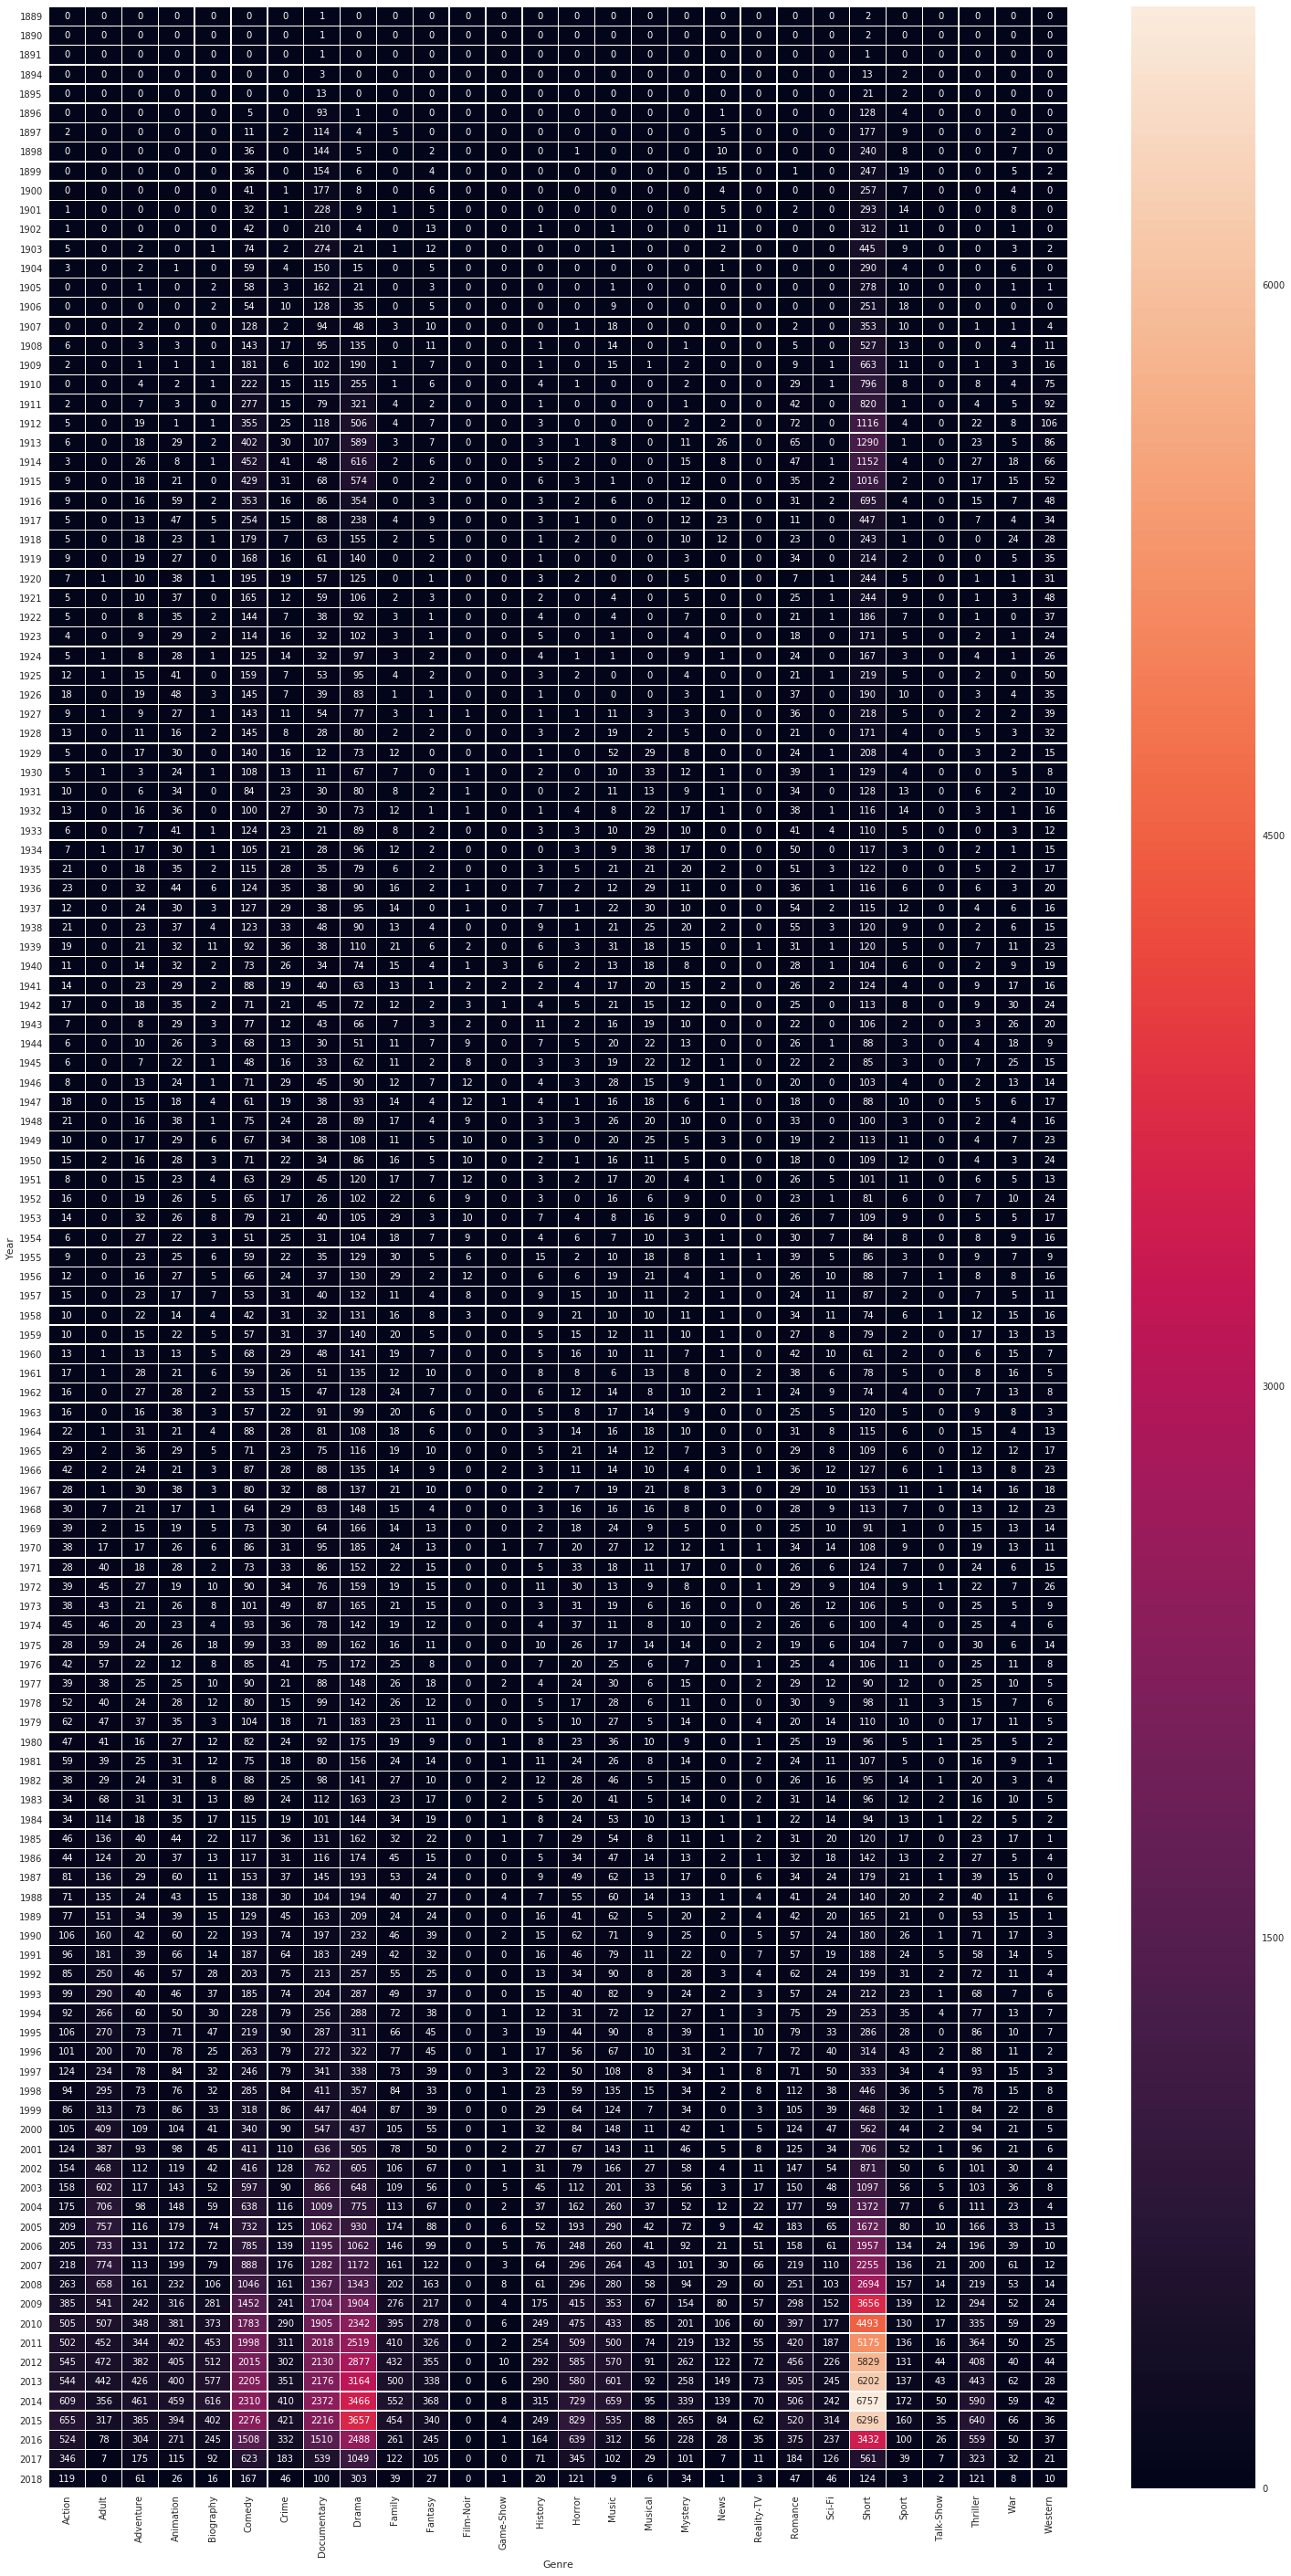

In [28]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(25, 50))
sns.heatmap(released_genres_pivot, annot=True, fmt=".0f", linewidths=.5, ax=ax)

I got really curious on that fenomenom with 'Short' genre. So I searched through imdb what is the definition and was exactly what I was thinking: "Short: Any theatrical film or made-for-video title with a running time of less than 45 minutes, i.e., 44 minutes or less, or any TV series or TV movie with a running time of less than 22 minutes, i.e. 21 minutes or less. (A "half-hour" television program should not be listed as a Short.) If known, please submit the running time if we do not have one on record. Objective." https://help.imdb.com/article/contribution/titles/genres/GZDRMS6R742JRGAG?ref_=helpms_helpart_inline#short


So, I decided to see how the heatmap would look like without the 'short' genre and I have two reasons for this:

1) We can assume that actually 'short' is type of movie not a genre exactly. A short movie can be a drama, a thriller or whatever.

2) The incidence of 'Short' movies is very high and we might be losing track of other fenomons throughout the years

Then, let's give it a try...

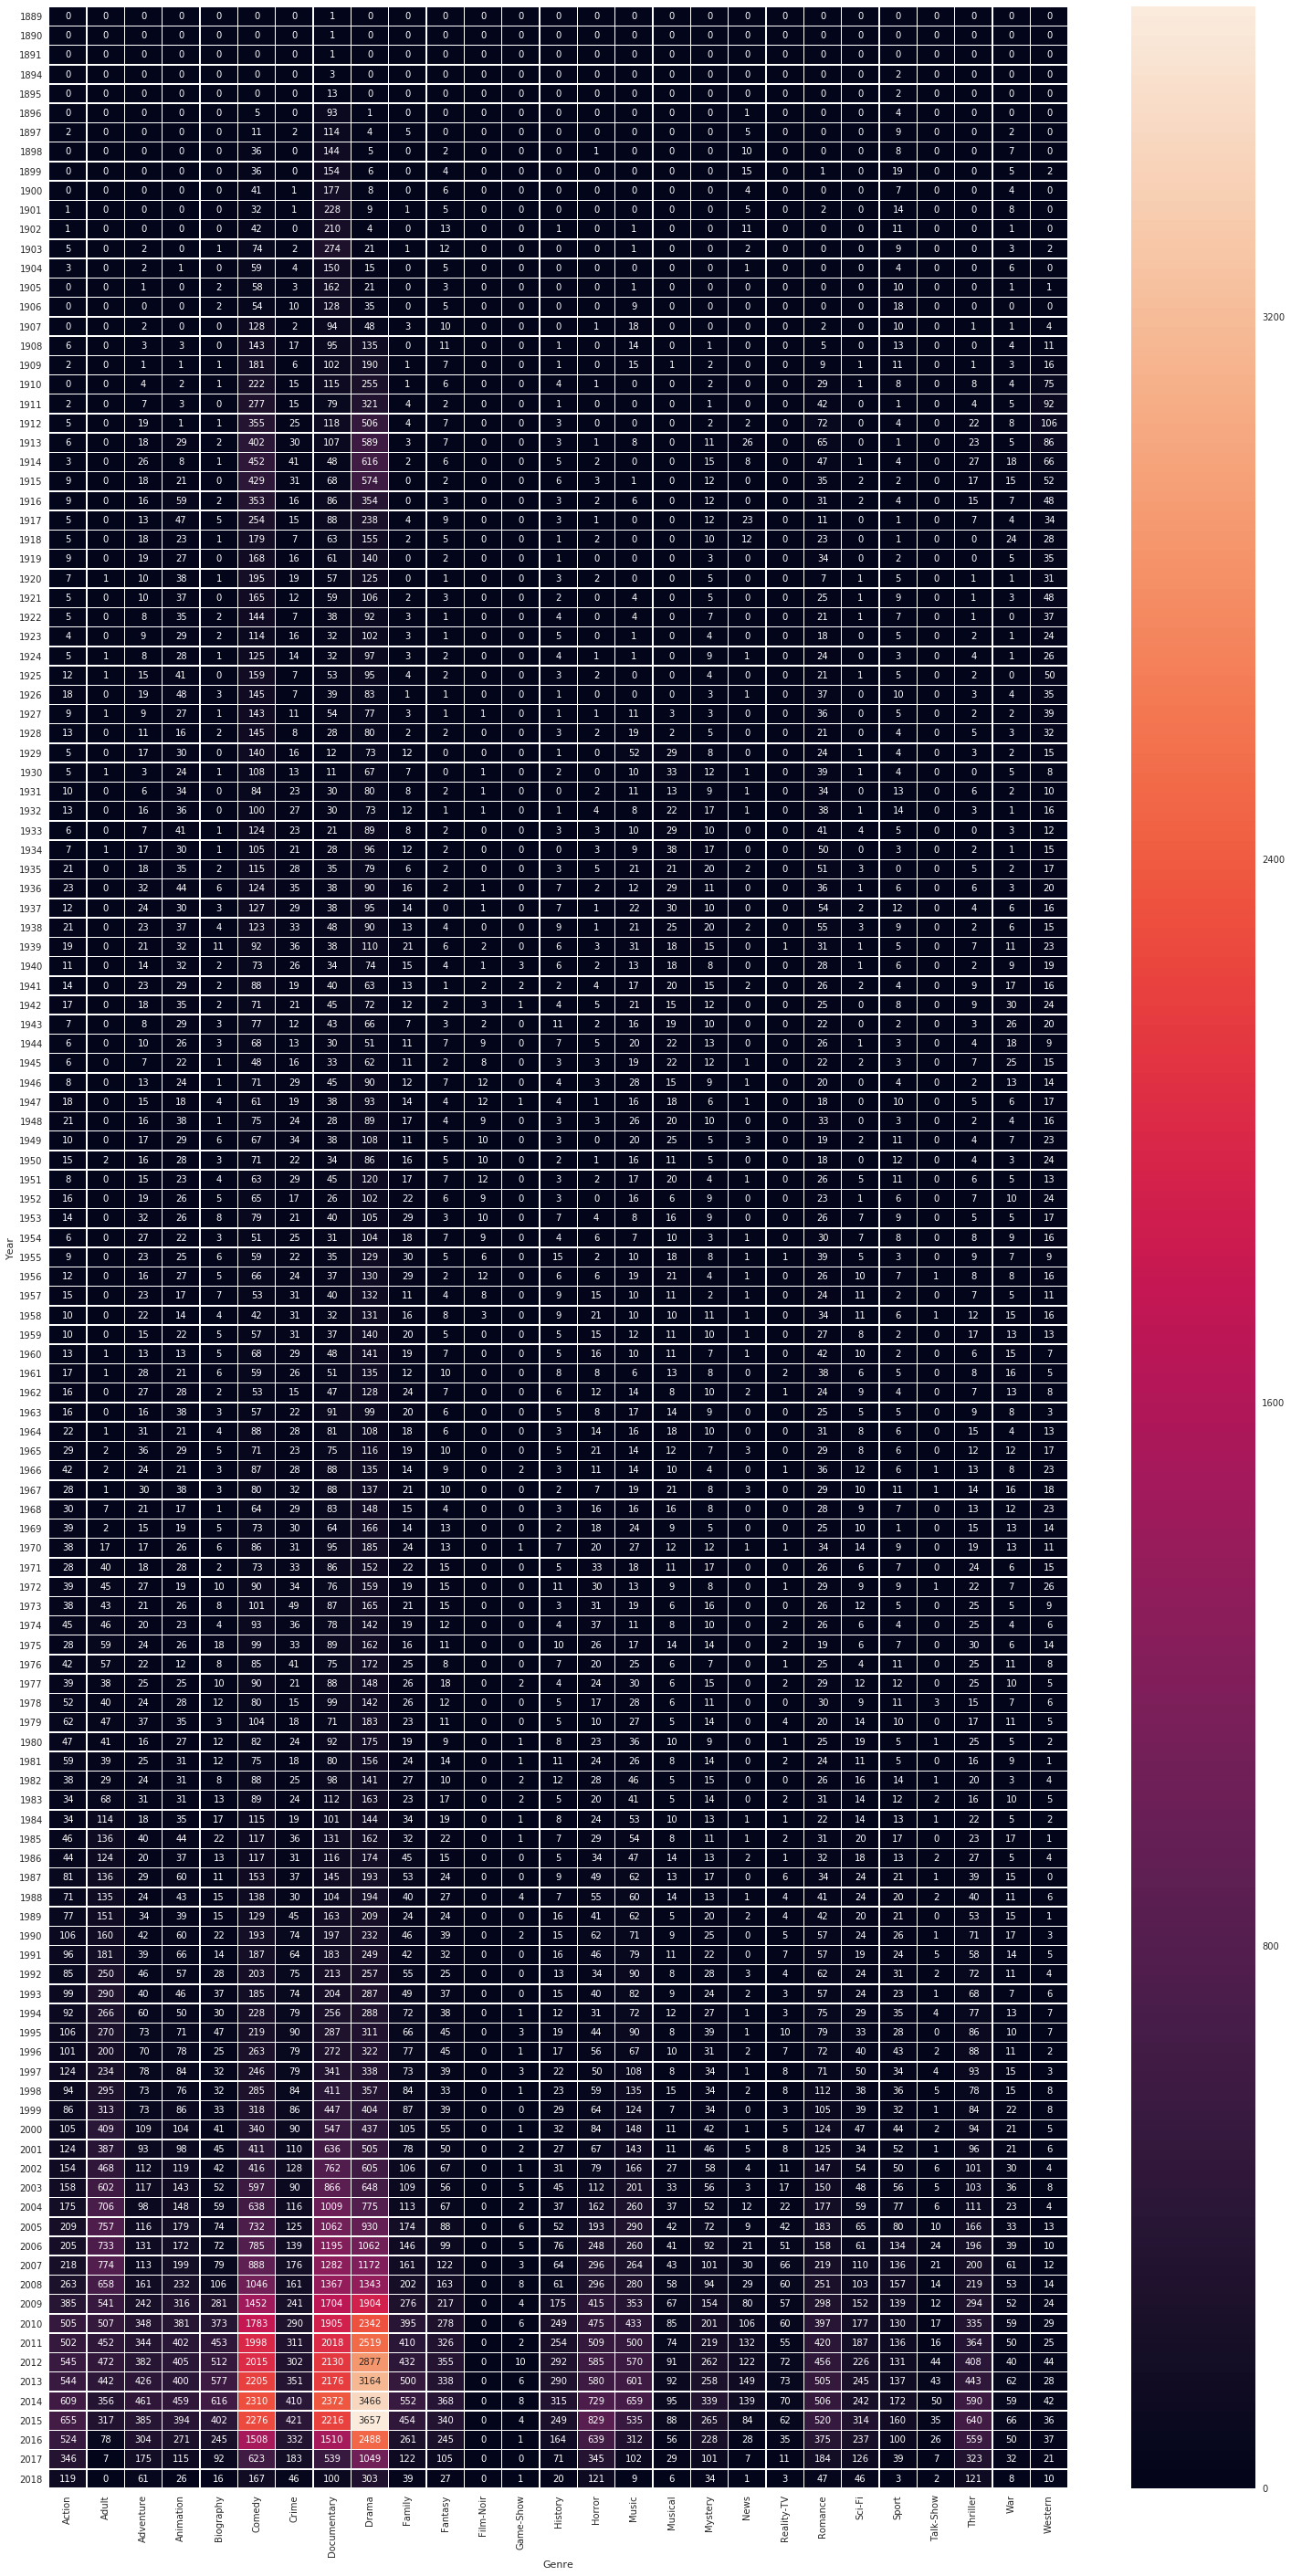

In [29]:
# Draw a heatmap with the numeric values in each cell
released_genres_pivot = pd.DataFrame(released_genres[released_genres.Genre != 'Short'].pivot_table(index='Year', columns='Genre', values='imdbID', aggfunc='count')).reset_index().fillna(0).sort_values("Year", ascending=True).set_index('Year')
f, ax = plt.subplots(figsize=(25, 50))
sns.heatmap(released_genres_pivot, annot=True, fmt=".0f", linewidths=.5, ax=ax)

# 3. Do the actors or writers prefer a genre?

## Writer

### 3.1 Data Cleaning

Removing 'Unamed: 0' column from dataframes

In [30]:
actors.drop(['Unnamed: 0'],axis=1,inplace=True)
writer.drop(['Unnamed: 0'],axis=1,inplace=True)

Since we have a huge dataframe of movies, lets focus only in one market: USA

In [70]:
movies_usa = movies[movies.Country == 'USA'][['imdbID']]

Same way, in writers dataset we have a lot of responsibility, so let's focus only on people that had the reponsibility with the story

In [69]:
writer_story = writer[writer.Responsibility == 'story']

### 3.2 Data Transform

First, lets filter the writers using our filtered movies dataframe

In [71]:
movies_writer = pd.merge(movies_usa, writer_story, on='imdbID', how='inner')

Ok, now we have to understand how many movies each 'writer' has participation on.

In [73]:
movies_writer = pd.DataFrame(movies_writer.groupby('Person')['imdbID'].nunique()).reset_index().rename(columns={'imdbID':'total'})

Using describe() method, we can check some basic statistic metrics and the percentiles. Almost the entire dataframe are populated with writers that has only 1 movie related on. Of course, there no sense in using these guys in our analysis.

In [74]:
movies_writer.describe()

,total
count,8404.000000
mean,1.301285
std,1.336386
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,38.000000


Here I tried different numbers of movies related to the writers, until i find something that makes sense to me. Thought that 10 was a very reasonable quantity to define is the writer has a preference or not.

In [85]:
movies_writer[movies_writer.total >= 10].describe()

,total
count,551.000000
mean,19.758621
std,8.434873
min,10.000000
25%,13.000000
50%,19.000000
75%,24.000000
max,38.000000


Then, we filter the dataframe using our previous defined parameter

In [76]:
movies_writer = movies_writer[movies_writer.total >= 10]

Now, let's just give the imdbID back to the persons

In [77]:
movies_writer = pd.merge(movies_writer, writer, on='Person', how='inner')

Since we're using the 'Person' as primary key, we have to filter the responsibility again

In [78]:
movies_writer = movies_writer[movies_writer.Responsibility == 'story']

Merging genres to movie_writers df to acquire Genre column to our dataframe.

In [79]:
movies_writer_genre = pd.merge(movies_writer, genres, on='imdbID', how='inner')

Now, let's crete a pivot table counting every Genre by Person.

In [80]:
movies_writer_genre_pivot = movies_writer_genre.pivot_table(index='Person', columns='Genre', values='imdbID', aggfunc='count').reset_index().fillna(0).set_index('Person')

### 3.3 Analysis

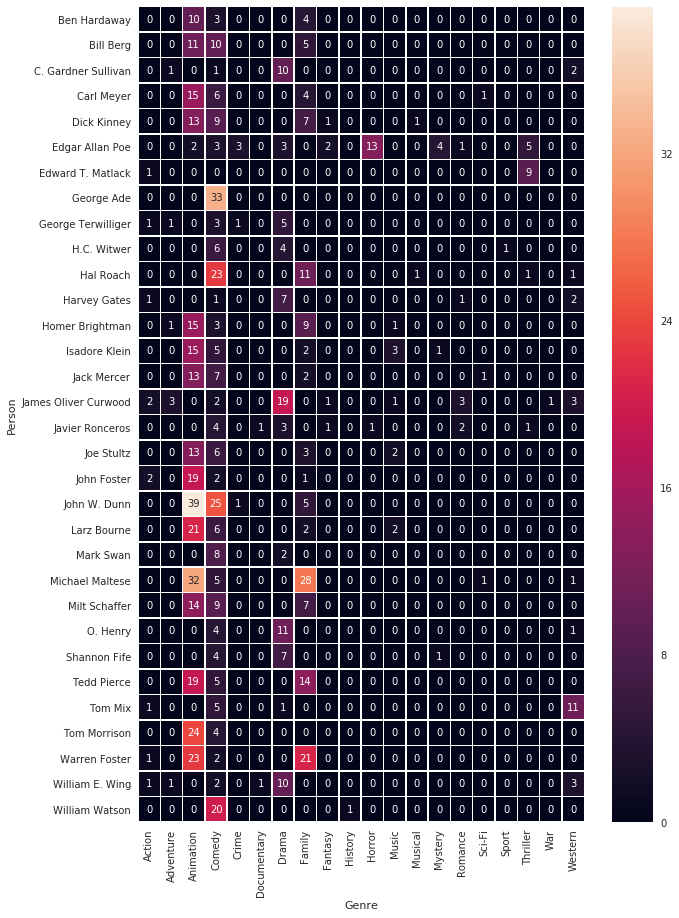

In [81]:
f, ax = plt.subplots(figsize=(10, 15))
sns.heatmap(movies_writer_genre_pivot.drop(['Short'],axis=1), annot=True, fmt=".0f", linewidths=.5, ax=ax)

## Actors

For actors we're going to do the same steps as writers, so I'll write everything in one block and then just display the heatmap into a different block

In [135]:
movies_usa = movies[movies.Country == 'USA'][['imdbID']]

movies_actors = pd.merge(actors, movies_usa, on='imdbID',how='inner')

movies_actors = pd.DataFrame(movies_actors.groupby('Actors')['imdbID'].nunique()).reset_index().rename(columns={'imdbID':'total'})

movies_actors = movies_actors[(movies_actors.total >= 9) & (movies_actors.total <= 80) ]

movies_actors = pd.merge(movies_actors, actors, on='Actors', how='inner')

movies_actors_genre = pd.merge(movies_actors, genres, on='imdbID', how='inner')

movies_actors_genre.sort_values(['Actors'],ascending=1, inplace=True)

movies_actors_genre_pivot = movies_actors_genre.pivot_table(index='Actors', columns='Genre', values='imdbID', aggfunc='count').reset_index().fillna(0).set_index('Actors')

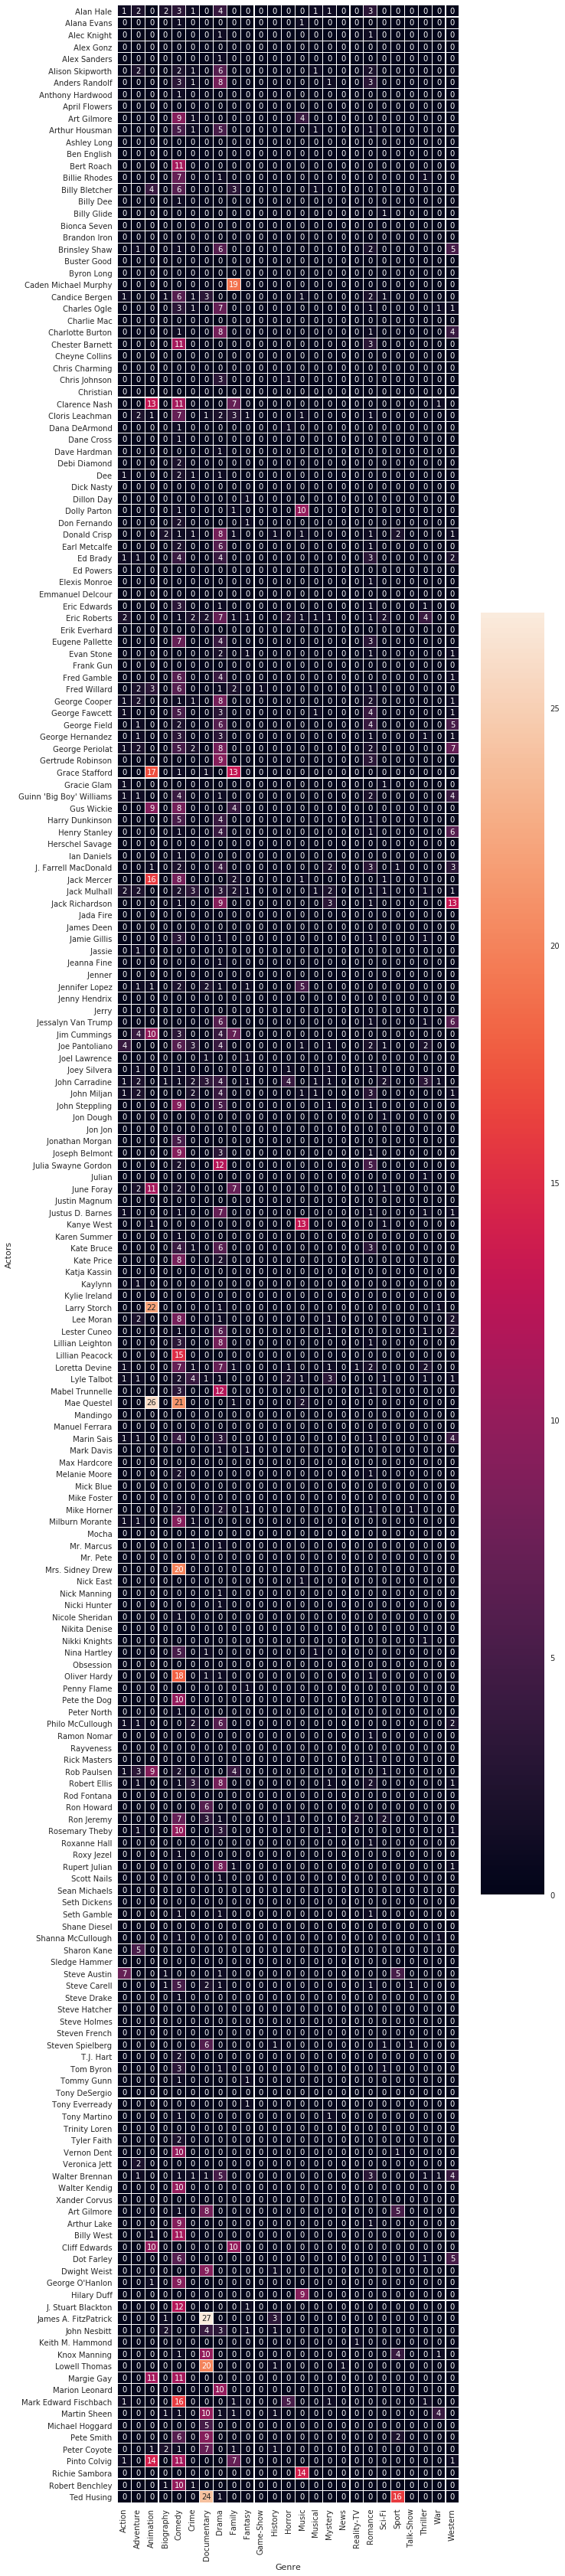

In [137]:
f, ax = plt.subplots(figsize=(10, 60))
sns.heatmap(movies_actors_genre_pivot.drop(['Short','Adult'],axis=1), annot=True, fmt=".0f", linewidths=.05, ax=ax)